# IMDB Movie Review Sentiment Analysis

<br>
IMDB is an online database of information related to films, tv, series, etc. This dataset contains reviews that divided into positive and negative reviews. So, in this project we will do sentiment analysis where we asked to classify whether a review is tend to positive or negative.
<br>

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
<br>
Attributes:
- Review
- Sentiment

In [1]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


## EDA
1. Transform label into number
2. View data distribution (imbalance or not)
3. View token length distribution
4. Preview on some positive and negative reviews

In [2]:
# read data
data = pd.read_csv('../data/imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


As we can see, we have sentiment label in text format. In this case, we need to transform these labels into number.
<br><br>
We will define `positive` as `1` and `negative` as `0`.

In [3]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 692520.20it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Let's see if we have an imbalance case by looking at total dataset of each positive and negative classes

In [4]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Seems we have a good enough dataset. Here we got balance dataset with 25K for each labels.

Now, we want to see token distribution in our dataset. We want to see token distribution for each positive and negative labels. We will split sentences by whitespaces and count total tokens by `len()` function.

In [5]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 53465.54it/s]


In [6]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 10. While the average token is 232.

In [7]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

And for negative reviews, we have maximum and minimum token respectively 1522 and 4. While the average token is 229.

According to both descriptive statistics, both has identical maximum, minimum, and average token length.

<Figure size 360x576 with 0 Axes>

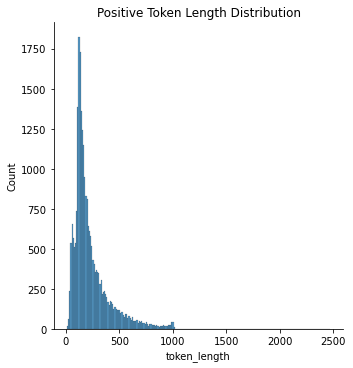

In [8]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 360x576 with 0 Axes>

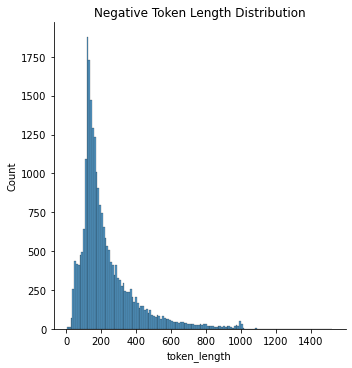

In [9]:
plt.figure(figsize=(5, 8))
sns.displot(data_neg, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

Now let's see some reviews from positive and negative reviews.

In [11]:
# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


## Clean and Preprocess
1. Create text cleaning method pipeline
2. Create text preprocessing method pipeline
3. Save preprocessed data as new csv file

Here we will define text cleaning pipeline which consist of several methods below:
1. Remove links
2. Remove punctuations, but here we exclude dot (.), comma (,), hyphen (-), exclamation (!), and question mark(?).
3. Remove HTML tags
4. Space between punctuation, because we want to treat some excluded punctuations as individual token
5. Remove numbers
6. Remove additional whitespaces
7. Remove nonascii characters
8. Remove emoji

In [12]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

Now, after clean the texts we will proceed to preprocessing methods. Here we will define several preprocessing methods as follows:
1. Tokenize, where we split the text by words using `nltk` package
2. Remove stopwords. Here we will use English stopwords provided by `nltk`
3. Lemmatization, where we transform words into its original form by removing their suffix

In [13]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [14]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [02:59<00:00, 277.87it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


Finally, after doing data preprocessing, we save our processed dataset into a new csv file for further usage.

In [15]:
# keep only processed and label columns
data[['processed', 'label']].to_csv('../data/imdb_processed.csv', index=False, header=True)

## Prepare Dataset
<br>
By now we already have our processed data. Before we proceed to classification step, we need to transform our text into vector representations. And in order to do that, we need to build a vocabulary that maps each token to ids.
<br><br>
Here are the following steps that we will do:

1. Build a vocabulary
2. Encode reviews
3. Pad short reviews and trim long reviews
4. Make train test val split
5. Prepare dataloaders and batches

In [2]:
# read processed data
data = pd.read_csv('../data/imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

Now, before we start build our vocabulary we need to gather all reviews into a single string variable. Then, we will split the whole reviews by whitespaces.

In [3]:
# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

Here we can utilize python built-in library `Counter` to easily get unique words in reviews. We then start indexing our unique words from 1, because we will use index 0 for padding `<PAD>` token.

In [4]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

Now, let's encode our reviews by converting each token into corresponding index in vocabulary that we just created.

In [5]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 50000/50000 [00:03<00:00, 12710.18it/s]

[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


Great! Now we have successfully transform token to corresponding id. 
<br><br>
But now we got another problem. As we know, the length review sometimes is different. So, first we need to define our maximum sequence length. Then, for each reviews that shorter than our predefined sequence length we will add `padding` token. Otherwise, we will `trim` the reviews.

In [6]:
# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

seq_length = 200
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[ 191, 1083,  930,   81, 3724,  186, 3030,    1,  118,  114],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [7]:
# get labels as numpy
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

*Train test split!*
<br><br>
After we encode and `pad` / `trim` our dataset, it's time to make `train`, `validation`, and `test` set! Here we will try to implement train test split by ourselves.
<br><br><br>
So, here is the scenario: first we divide our dataset into 2 parts, `train` and `test` set. Then, we divide `train` again into `train` and `validation`. And of course we need to define the  `ratio` before we split our dataset.

In [8]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 200)
Validation set: (7500, 200)
Test set: (7500, 200)


In [9]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


Finally, we will pass our dataset into `TensorDataset` and then `DataLoader`. Remember that we have already split our dataset into train, test, and validation set. Hence, we need to create loaders for each set. And to do that, we need to convert our numpy formatted dataset into `TensorDataset`. Then, we need to specify our `batch_size` into `DataLoader` and pass our tensor dataset. Don't forget to give parameter `shuffle=True` to prevent our model in learning in chronological orders.

In [10]:
# define batch size
batch_size = 32

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

Let's have a look to our just created loader.
<br>
Here we expecting the shape of `X` is **(batch_size, sequence_length)**, while the shape of `Y` is **(batch_size)**

In [11]:
# check our batches
dataiter = iter(trainloader)
x, y = dataiter.next()

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([32, 200])
Sample batch input: 
 tensor([[    0,     0,     0,  ...,  2464,  4516,     1],
        [    0,     0,     0,  ..., 49651,  1256,     9],
        [    0,     0,     0,  ...,   224,   155,     1],
        ...,
        [    0,     0,     0,  ...,  9066,   546,  2618],
        [    0,     0,     0,  ...,    35,  1518,     1],
        [    0,     0,     0,  ...,  4567,   793,     1]], dtype=torch.int32)

Sample label size:  torch.Size([32])
Sample label input: 
 tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0])


## Modelling

We are arrived on the most interesting part of ML project, that is modelling *yeay*  🥳
<br>
In this project, we will use LSTM (Long Short-Term Memory) as our model. I decide to use this model because in text data, sometimes each word has relations with its next or previous words. Hence, we can treat them as sequential case and since most traditional ML seems does not learning text sequentially, we can use RNN-based model as a solution.

<br>
But before we talk further about this model, it's better for you to see the RNN-based model illustration below.

![RNN-Relations](images/diags.jpeg)

So, the RNN-based models can be used for many purposes. But in this case, we will only talk about `many-to-one` use case. Because, the real process behind is we are feeding word by word to the network sequentially, and each time we feed the words we will get `output vector` and `hidden_state`; where we are only passing `hidden_state` into next sequences and ignore the `output vector`. We will take only the `output vector` from the very last sequence, because it contains all the *summary* of the whole words before.
<br><br>
After taking the `output vector` from the last sequence, we will feed it to **Sigmoid** layer, because it will *squash* values in the output vector into 2 classes; which is *positive* and *negative* in this case. To see how Sigmoid layer actually work, please see the illustration below.

![Sigmoid](images/Sigmoid-function.png)

So, as you can see above, Sigmoid has default threshold 0.5. And all values above this threshold will be considered as class 1, and the otherwise will be considered as class 0.

Now, we will talk about steps we are going to do:
<br>

1. Build network architecture
2. Define model hyperparameters
3. Setup training config
4. Write training-validation loop
5. Plot Loss
6. Inference on test set
7. Evaluation metrics

In [34]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

So, we just created our simple neural network consisting of several layers as follows:
- Embedding layer, where we can reduce the dimensionality of our vocabulary by learning its representation.
- LSTM layer, which will have the most work of our model
- Dropout layer, is the layer that have a task to reduce noise in our model. So it expected to prevent our model being overfit.
- Fully connected (Dense) layer, that classify our output vector from LSTM.
- Sigmoid layer, that *translates* the output of fully connected layer and give us view to the outputs more clearly.

<br><br>
Since training neural network model takes quite long time sometimes, we can speed up the training process by using GPU. But as not all device has GPU installed and/or supported, we will try to detect automatically if the device has GPU or not.

In [35]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Here we define our model hyperparameters that we can modify to tune our model to produce the best performance.

In [36]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 256
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Then, we define some training config for our model. Since we have *binary classification* task, we will use **Binary Cross Entropy Loss (BCELoss)** as our loss function. And we will use **Adam** as optimizer as it shown in many references that it could find converge point quickly.
<br><br>
We also define `early_stop` mechanism that expected to prevent our model being overfit by stop training once the monitored parameters (e.g. `val_loss` or `val_acc`) is not improved by several epochs anymore.

In [37]:
# training config
lr = 0.0005
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 5
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

**This is our main part!**
<br>
So, here we define training and validation loop. We will use only 5 epochs and see if we need more or less epochs to obtain good performance. We log our loss and accuracy for each epochs, so we can plot them later to see how the performances.

In [38]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), '../models/sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:  20%|██        | 1/5 [04:32<18:08, 272.03s/it, Val Loss: 0.486 | Val Acc: 0.768]

Epoch 1/5 | Train Loss: 0.603 Train Acc: 0.667 | Val Loss: 0.486 Val Acc: 0.768


Training:  60%|██████    | 3/5 [10:01<07:01, 210.74s/it, Val Loss: 0.356 | Val Acc: 0.851]

Epoch 2/5 | Train Loss: 0.408 Train Acc: 0.825 | Val Loss: 0.356 Val Acc: 0.851


Training:  80%|████████  | 4/5 [15:04<04:07, 247.28s/it, Val Loss: 0.327 | Val Acc: 0.868]

Epoch 3/5 | Train Loss: 0.286 Train Acc: 0.884 | Val Loss: 0.327 Val Acc: 0.868


Training: 6it [20:25, 213.44s/it, Training batch 0/1094]                                  

Epoch 4/5 | Train Loss: 0.208 Train Acc: 0.921 | Val Loss: 0.348 Val Acc: 0.862
[WARNING] Validation loss did not improved (0.327 --> 0.348)


Training: 100%|██████████| 5/5 [26:47<00:00, 321.47s/it, Val Loss: 0.369 | Val Acc: 0.866]

Epoch 5/5 | Train Loss: 0.150 Train Acc: 0.946 | Val Loss: 0.369 Val Acc: 0.866
[WARNING] Validation loss did not improved (0.327 --> 0.369)


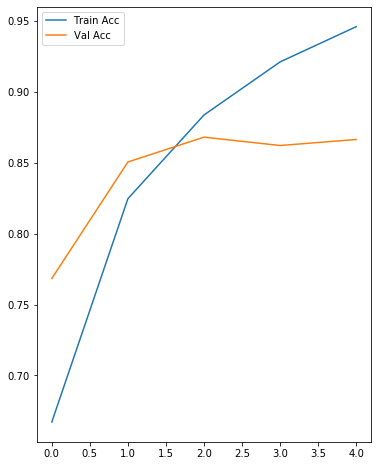

In [39]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

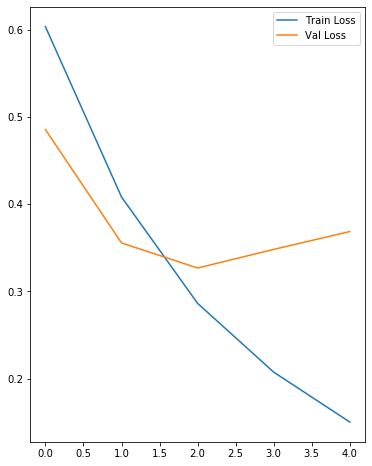

In [41]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

So, as we can see from both graph above we can conclude that our model is tend to overfitting. As you can see, the validation loss start to increasing after 4th epochs, and the validation accuracy also didn't improved significantly anymore after 4th epochs.
<br><br>
Now let's see how is our model performance on predicting unseen data!

## Inference

Here we want to see our model performance on predicting unseen data, that is test set. The loop is quite similar with train loop, but we won't perform any backpropagation here. And also, we turned off the gradient by calling `torch.no_grad()` to keep some memory allocation and speeding up inference process.

In [49]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 235/235 [00:21<00:00, 10.88it/s]

Accuracy: 0.8603, Loss: 0.3665


Surprisingly, our model accuracy on test data is quite good! It could predict unseen data `86.03%` correctly.
<br><br>
Nevertheless, we still have an overfitting issue that we need to solve in the future.

## Evaluation Metrics

In [50]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3828
           1       0.85      0.87      0.86      3672

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



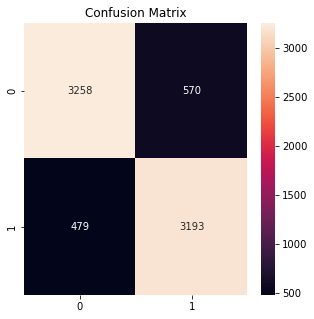

In [56]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

According to the classification report it can be seen that our accuracy is not tends to specific class. And the confusion matrix also shown that there is no big difference between misclassified positive and negative reviews. This may happens because we have a balance datasets.

## Conclusion
To sum up, here what we did along the project:
- We taken IMDB movie review from kaggle consist of 50K positive and negative reviews and fortunately it has balance dataset.
- We transform our label into 1 and 0 for positive and negative class respectively
- We create our own cleaning and preprocessing script
- Then we built vocabulary, encoding all reviews, add padding/trimming mechanism, making train test and validation set, create dataloader to make batches data
- We built our model architecture, defining hyperparameters, writing training and validation loop, and we plot our loss and accuracies.
- Then we do inference on test data, and surprisingly it still has a quite good performance with accuracy ~86%
- Finally, we see our model evaluation using various metrics and plotting confusion matrix which showing that our model could classify most data correctly and not tends to specific class as we have balanced dataset.

### References:
- [Udacity - Introduction to PyTorch](https://classroom.udacity.com/courses/ud188)
- [The Unreasonable Effectiveness of RNNs by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [PyTorch Name Classification project](https://github.com/python-engineer/pytorch-examples/tree/master/rnn-name-classification)
- [My exploration project in RNNs](https://github.com/fhrzn/all-about-rnn)

<hr>

## Thank you for reading! Спасибо! 🙇‍♂️
```Made with effort by Affandy Fahrizain```

My other projects:
- Github - [https://github.com/fhrzn](https://github.com/fhrzn)

For further discussion, don't hesitate to catch me up at:
- Gmail - [fahri.lafa@gmail.com](mailto:fahri.lafa@gmail.com)
- Linkedin - [linkedin.com/in/fahrizainn](linkedin.com/in/fahrizainn)